In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

## 1.前导知识复习

In [2]:
print(np.sign(9))   
#重要函数，帮助我们判断我们这个值到底是大于0还是小于0还是等于0，如果这个值大于0，那么就返回1，如果这个值小于0，那么就返回-1

1


#### np.sign()这个函数非常好用，因为我们之前双均线策略其实写了这么多代码就是为了获得signal或者regime或者position。而如果有了np.sign就可以很好实现这个目标。
#### 比如过去涨，那么我们就计算return，然后np.sign(return)，如果是涨的，那么return就是正的，那么返回1，如果return跌的，那么return就是负的，那么返回-1。这样子我们就可以根据这个返回值来看做多还是做空
#### 所以np.sign()用在momentum这个策略里面天衣无缝的配合，因为我们并不关心return到底具体值是多少，我们只要看趋势。

In [3]:
date = '2014-02-03'
print(type(date))   #这个值的类型是属于string类型，但是并不是时间类型。

<class 'str'>


In [4]:
date = pd.to_datetime(date)  #把一个数据转换成伟时间数据
print(type(date))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


## 2.数据准备 & 回测准备

In [5]:
data = pdr.get_data_yahoo('^GSPC',start = '2010-01-01',end = '2017-06-27')['Close']
data = pd.DataFrame(data)  #我们上面把数据的close抽出来，其实已经就不是dataframe类型了，已经变成了series了
data.rename(columns = {'Close':'Price'}, inplace = True)
data.head()

,Price
Date,
2010-01-04,1132.989990
2010-01-05,1136.520020
2010-01-06,1137.140015
2010-01-07,1141.689941
2010-01-08,1144.979980


## 3.策略开发思路

In [6]:
data['return'] = np.log(data['Price']/data['Price'].shift(1))
print(data.head())  #我们这里可以看到return列出现了。我们第一种思路说了就是看前一天return的情况，如果是正的，那么我们就做多，如果是负的，那么我们就做空
data['position'] = np.sign(data['return'])   #关键语句，np.sign()在很多地方都可以用到。这个就叫做是向量化
data.head()

                  Price    return
Date                             
2010-01-04  1132.989990       NaN
2010-01-05  1136.520020  0.003111
2010-01-06  1137.140015  0.000545
2010-01-07  1141.689941  0.003993
2010-01-08  1144.979980  0.002878


C:\Users\dell\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Price,return,position
Date,,,
2010-01-04,1132.989990,NaN,NaN
2010-01-05,1136.520020,0.003111,1.0
2010-01-06,1137.140015,0.000545,1.0
2010-01-07,1141.689941,0.003993,1.0
2010-01-08,1144.979980,0.002878,1.0


#### 有了signal，那么我们接下来就要算两个收益，一个是买入并持有的收益，一个是策略的收益

In [7]:
#买入并持有的收益我们直接对return进行累计求和即可
data['strategy'] = data['position'].shift(1)*data['return']  #这里还是和双均线策略一样，要注意未来函数
data.head()

,Price,return,position,strategy
Date,,,,
2010-01-04,1132.989990,NaN,NaN,NaN
2010-01-05,1136.520020,0.003111,1.0,NaN
2010-01-06,1137.140015,0.000545,1.0,0.000545
2010-01-07,1141.689941,0.003993,1.0,0.003993
2010-01-08,1144.979980,0.002878,1.0,0.002878


## 4.策略可视化

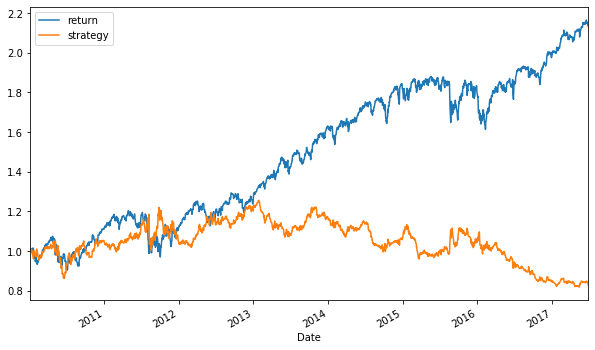

In [8]:
data[['return','strategy']].cumsum().apply(np.exp).plot(figsize = (10,6))
plt.show()

## 5.策略优化之思路——参数优化和穷举

In [9]:
data['position_5'] = np.sign(data['return'].rolling(5).mean())
data['strategy_5'] = data['position_5'].shift(1) * data['return']
data.head()#之所以前面5行都是nan，那么是因为rolling

,Price,return,position,strategy,position_5,strategy_5
Date,,,,,,
2010-01-04,1132.989990,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.520020,0.003111,1.0,NaN,NaN,NaN
2010-01-06,1137.140015,0.000545,1.0,0.000545,NaN,NaN
2010-01-07,1141.689941,0.003993,1.0,0.003993,NaN,NaN
2010-01-08,1144.979980,0.002878,1.0,0.002878,NaN,NaN


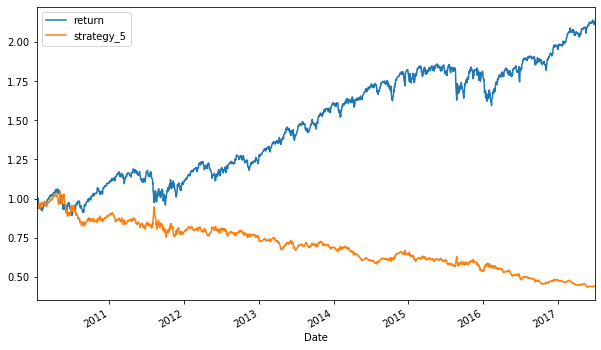

In [10]:
data[['return','strategy_5']].dropna().cumsum().apply(np.exp).plot(figsize = (10,6))
plt.show()   #效果真的非常不好

### 接下来穷举：我们需要把时间改一下,需要去寻找最适合的一个参数

#### 参数寻优——使用离散Return计算方法
#### 连续return和连续return区别：https://www.zhihu.com/question/30113132

In [11]:
data['return_dis'] = data['Price'].pct_change()  #我们前面算return使用np.log()这其实是连续型的return，这里我们算的是离散型的return
#data['return_dis'] = data['Price']/data['Price'].shift(1) - 1  -> 这样也是可以的
data['return_dis_cum'] = (data['return_dis']+1).cumprod()   #注意，我们如果算log return的累积那么就是用cumsum().apply(np.exp)，而如果是离散的，那么就是用cumprod()
data.head()

,Price,return,position,strategy,position_5,strategy_5,return_dis,return_dis_cum
Date,,,,,,,,
2010-01-04,1132.989990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.520020,0.003111,1.0,NaN,NaN,NaN,0.003116,1.003116
2010-01-06,1137.140015,0.000545,1.0,0.000545,NaN,NaN,0.000546,1.003663
2010-01-07,1141.689941,0.003993,1.0,0.003993,NaN,NaN,0.004001,1.007679
2010-01-08,1144.979980,0.002878,1.0,0.002878,NaN,NaN,0.002882,1.010583


In [12]:
price_plot = ['return_dis_cum']   #这是用来绘制图形的list,现在这个list里面只有一个东西，就是return_dis_cum
type(price_plot)   #是list，我们之所以要用list因为我们可以用到append方法，不断新添加我们的元素

list

#### 接下来我们想要画一张图，第一条线是股票本身的累积收益，然后我们要选取10,20,30,60天的平均收益。如果平均收益是正的，那么就做多，如果是负的，那么就做空。

In [13]:
for days in [10,20,30,60]:
    price_plot.append('strategy_cumr_%dd' % days)   #%d字符串格式化，是一个占位符
    data['position_%dd' % days] = np.where(data['return'].rolling(days).mean()>0,1,-1)
    data['strategy_%dd' % days] = data['position_%dd' % days].shift(1)*data['return']
    data['strategy_cumr_%dd' % days] = (data['strategy_%dd' % days] + 1).cumprod()

In [17]:
price_plot
data.head()

,Price,return,position,strategy,position_5,strategy_5,return_dis,return_dis_cum,position_10d,strategy_10d,strategy_cumr_10d,position_20d,strategy_20d,strategy_cumr_20d,position_30d,strategy_30d,strategy_cumr_30d,position_60d,strategy_60d,strategy_cumr_60d
Date,,,,,,,,,,,,,,,,,,,,
2010-01-04,1132.989990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN
2010-01-05,1136.520020,0.003111,1.0,NaN,NaN,NaN,0.003116,1.003116,-1,-0.003111,0.996889,-1,-0.003111,0.996889,-1,-0.003111,0.996889,-1,-0.003111,0.996889
2010-01-06,1137.140015,0.000545,1.0,0.000545,NaN,NaN,0.000546,1.003663,-1,-0.000545,0.996345,-1,-0.000545,0.996345,-1,-0.000545,0.996345,-1,-0.000545,0.996345
2010-01-07,1141.689941,0.003993,1.0,0.003993,NaN,NaN,0.004001,1.007679,-1,-0.003993,0.992367,-1,-0.003993,0.992367,-1,-0.003993,0.992367,-1,-0.003993,0.992367
2010-01-08,1144.979980,0.002878,1.0,0.002878,NaN,NaN,0.002882,1.010583,-1,-0.002878,0.989511,-1,-0.002878,0.989511,-1,-0.002878,0.989511,-1,-0.002878,0.989511


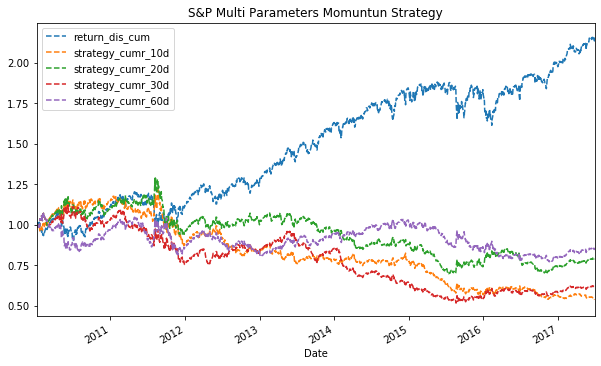

In [18]:
data[price_plot].dropna().plot(title = 'S&P Multi Parameters Momuntun Strategy',figsize = (10,6),style = ['--','--','--','--','--'])
plt.show()  #没有一个可以跑得赢大盘……

## 6.策略优化之——High Frequency Data用于Momentum策略

In [ ]:
SP = pdr.get_data_yahoo('^GSPC',ktype = '5')  #这里有问题，yahoo取不了5分钟数据。但是后面是完全一样，还是算return，position和strategy。